## Quickstart Guide

The Quickstart Guide will both introduce the data study challenge and provide a simple example using currently used methods.

Currently, eddy currents are typically measured and observed by:

    1) Interpolaing sparse sea surface height (SSH) onto a regular grid
    2) Applying an automatic eddy detection algorithm to detect eddies from SSH maps

The notebook is structured as follows:

    a) Plotting the data
    b) Optimal Interpolation using PyInterp
    c) Eddy detection using PyEddyTracker (WIP)



In [28]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
from datetime import datetime

### a) Plotting the data

- First let us load the gridded eNATL60 model data using xarray

In [29]:
model_dir = '/Volumes/JCHD/NOC/data/eNATL60/1h_GS12/'
model_file = 'eNATL60-BLB002_sossheig_1h_GS12_y2009m10d01.nc'

ds_model = xr.open_dataset(model_dir+model_file)
ds_model

<xarray.Dataset>
Dimensions:            (time_counter: 24, bnds: 2, lon: 181, lat: 181)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2009-10-01T00:30:00 ... ...
  * lon                (lon) float64 -67.0 -66.92 -66.83 ... -52.17 -52.08 -52.0
  * lat                (lat) float64 28.0 28.08 28.17 28.25 ... 42.83 42.92 43.0
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] ...
    sossheig           (time_counter, lat, lon) float32 ...
Attributes: (12/16)
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         /scratch/tmp/4503665/eNATL60-BLB002_1h_20090928_20091002_gr...
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2019-Feb-03 06:03:36 GMT
    ...           ...
    nj:           9
    file_name:    eNATL60-BLB002_1h_20090928_20091002_gridT-2D_20091001-20091...
    TimeStamp:    03/02/2019 09:02:10 +0100
    history:      Tue Feb 07 11:43:52 2023: cdo -L -remap,/var/folders/kh/l0n...
    NCO:          4.4.6
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

- Next we will load the observations. To load multiple files at once we using `xr.load_mfdataset()`

In [30]:
sat_dir = '/Volumes/JCHD/NOC/data/eNATL60/1h_GS12_L3/ALTIKA/'
sat_file = 'eNATL60-BLB002_sossheig_1h_GS12_L3_ALTIKA_y2020m09d*.nc'

ds_alk = xr.open_mfdataset(sat_dir + sat_file, combine='nested', concat_dim='z').load()
ds_alk

<xarray.Dataset>
Dimensions:       (z: 4493)
Coordinates:
    lon           (z) float64 -64.09 -64.11 -64.12 ... -57.8 -57.82 -57.84
    lat           (z) float64 28.05 28.11 28.17 28.23 ... 42.83 42.89 42.95
    time_counter  (z) datetime64[ns] 2020-09-01T09:53:23.543764992 ... 2020-0...
Dimensions without coordinates: z
Data variables:
    sossheig      (z) float64 0.2151 0.2153 0.215 ... -0.4675 -0.4542 -0.4408

- We will then use cartopy and matplotlib to plot the data

Text(0.5, 1.0, 'SSH Model')

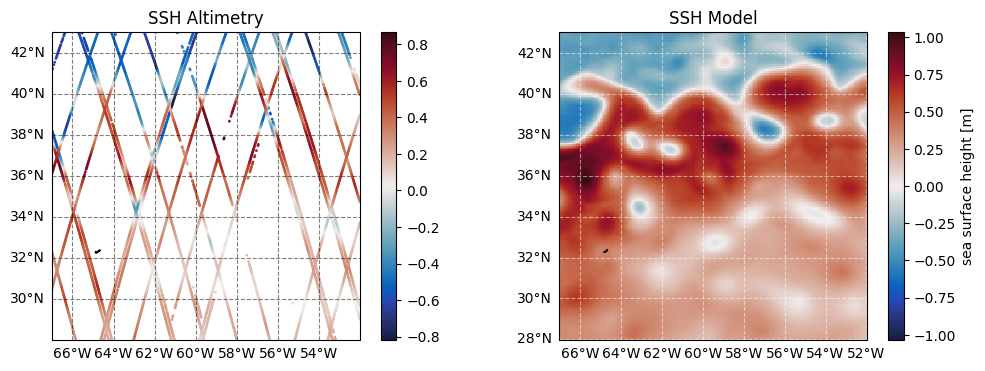

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot Altimetry
axs[0].coastlines()
axs[0].set_xlim(-67,-52)
axs[0].set_ylim(28, 43)
im = axs[0].scatter(ds_alk.lon, ds_alk.lat, c=ds_alk.sossheig, s=1, transform=ccrs.PlateCarree(), cmap=cmo.balance)
plt.colorbar(im, ax=axs[0])
axs[0].set_title('SSH Altimetry')
gl = axs[0].gridlines(linestyle='--', color='black', alpha=0.5, draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Plot eNATL60 model
axs[1].coastlines()
ds_model.sossheig[0].plot.pcolormesh(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmo.balance
    )
gl = axs[1].gridlines(linestyle='--', color='white', alpha=0.5, draw_labels=True)
gl.top_labels = False
gl.right_labels = False
axs[1].set_title('SSH Model')

### b) Optimal Interpolation

- To do the optimal interpolation we will use pyinterp

In [32]:
import pyinterp
import pyinterp.backends.xarray
import pyinterp.tests

- Let us load in data from all 4 satellites from the previous 30 days

In [33]:
ds_alk = xr.open_mfdataset('/Volumes/JCHD/NOC/data/eNATL60/1h_GS12_L3/ALTIKA/eNATL60-BLB002_sossheig_1h_GS12_L3_ALTIKA_y2020m09*.nc', combine='nested', concat_dim='z').load()
ds_h2b = xr.open_mfdataset('/Volumes/JCHD/NOC/data/eNATL60/1h_GS12_L3/H2B/eNATL60-BLB002_sossheig_1h_GS12_L3_H2B_y2020m09*.nc', combine='nested', concat_dim='z').load()
ds_s3a = xr.open_mfdataset('/Volumes/JCHD/NOC/data/eNATL60/1h_GS12_L3/SENTINEL3A/eNATL60-BLB002_sossheig_1h_GS12_L3_SENTINEL3A_y2020m09*.nc', combine='nested', concat_dim='z').load()
ds_s3b = xr.open_mfdataset('/Volumes/JCHD/NOC/data/eNATL60/1h_GS12_L3/SENTINEL3B/eNATL60-BLB002_sossheig_1h_GS12_L3_SENTINEL3B_y2020m09*.nc', combine='nested', concat_dim='z').load()

# Concatenate all satellite data
ds_sat = xr.concat([ds_alk, ds_h2b, ds_s3a, ds_s3b], dim='z')

- Define pyinterp interpolator mesh

In [34]:
size = ds_sat.sossheig.values.shape[0]
lons = ds_sat.lon.values
lats = ds_sat.lat.values
data = ds_sat.sossheig.values

mesh = pyinterp.RTree()
mesh.packing(np.vstack((lons, lats)).T, data)

- Create grid to interpolate onto

In [128]:
# Create grid to interpolate onto
step = 1 / 4                            # 1/4° grid resolution
mx, my = np.meshgrid(
    np.arange(-67, -52, step),
    np.arange(28, 43, step),
    indexing='ij'
)

# Interpolation with inverse distance weighting
idw, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.ravel(), my.ravel())).T,
    within = False,
    k=20,
    num_threads=0
    )
idw = idw.reshape(mx.shape)

# Interpolation with radial basis function
rbf, neighbors = mesh.radial_basis_function(
    np.vstack((mx.ravel(), my.ravel())).T,
    within = False,
    k=20,
    rbf='linear',
    smooth = 1e-4,
    num_threads=0
    )
rbf = rbf.reshape(mx.shape)

# Interpolation with Universial Kriging
kriging, neighbors = mesh.universal_kriging(
    np.vstack((mx.ravel(), my.ravel())).T,
    within = False,
    k=20,
    covariance='matern_12',
    alpha=100_000,
)
kriging = kriging.reshape(mx.shape)


- Get ground truth field from the object

In [36]:
# Ground truth SSH
model_dir = '/Volumes/JCHD/NOC/data/eNATL60/1h_GS12/'
model_file = 'eNATL60-BLB002_sossheig_1h_GS12_y2009m09d30.nc'
ds_model = xr.open_dataset(model_dir+model_file)


- Plot ground truth and interpolations

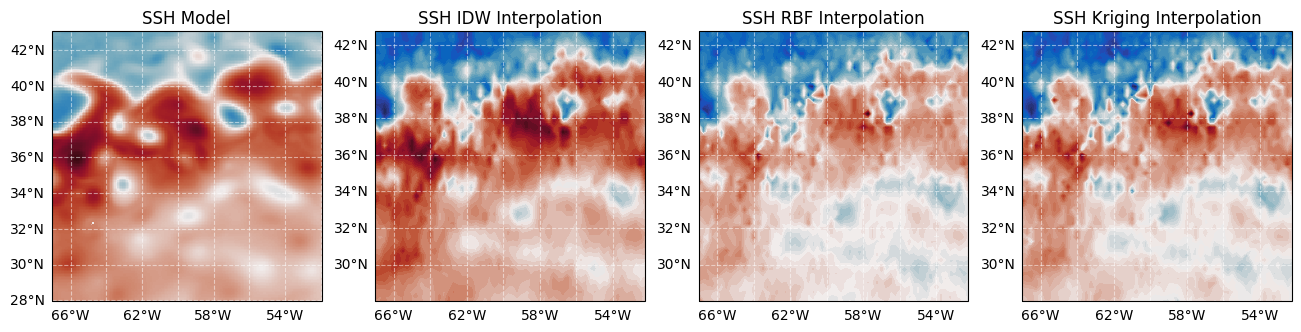

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(16,4), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.ravel()

ds_model.sossheig[0].plot.pcolormesh(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmo.balance,
    add_colorbar=False
    )
gl = axs[0].gridlines(linestyle='--', color='white', alpha=0.5, draw_labels=True)
gl.top_labels = False
gl.right_labels = False
axs[0].set_title('SSH Model')

pcm = axs[1].contourf(mx, my, idw, levels=50, transform=ccrs.PlateCarree(), cmap=cmo.balance)
gl = axs[1].gridlines(linestyle='--', color='white', alpha=0.5, draw_labels=True)
gl.top_labels = False
gl.right_labels = False
axs[1].set_title('SSH IDW Interpolation')

pcm = axs[2].contourf(mx, my, rbf, levels=50, transform=ccrs.PlateCarree(), cmap=cmo.balance)
gl = axs[2].gridlines(linestyle='--', color='white', alpha=0.5, draw_labels=True)
gl.top_labels = False
gl.right_labels = False
axs[2].set_title('SSH RBF Interpolation')

pcm = axs[3].contourf(mx, my, kriging, levels=50, transform=ccrs.PlateCarree(), cmap=cmo.balance)
gl = axs[3].gridlines(linestyle='--', color='white', alpha=0.5, draw_labels=True)
gl.top_labels = False
gl.right_labels = False
axs[3].set_title('SSH Kriging Interpolation')

plt.show()

- Compute statistics to calculate interpolation accuracy. For this we consider the RMSE between the interpolate predictions and the ground truth

In [135]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

gt = ds_model.sossheig[-1].values
gt = gt[::3,::3][:-1,:-1].flatten()

print('IDW RMSE: ', rmse(idw.flatten(), gt))
print('RBG RMSE: ', rmse(rbf.flatten(), gt))
print('Kriging RMSE: ', rmse(kriging.flatten(), gt))


IDW RMSE:  0.454685514432602
RBG RMSE:  0.46106877446637395
Kriging RMSE:  0.46420929284587154


### c) Detecting Eddies

In [87]:
import py_eddy_tracker
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours


In [88]:
def start_axes(title):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9], projection=ccrs.PlateCarree())
    ax.set_title(title)
    return ax

def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

We assume pixel position of grid is centered for /Volumes/JCHD/NOC/data/eNATL60/1h_GS12/eNATL60-BLB002_sossheig_1h_GS12_y2009m10d01.nc


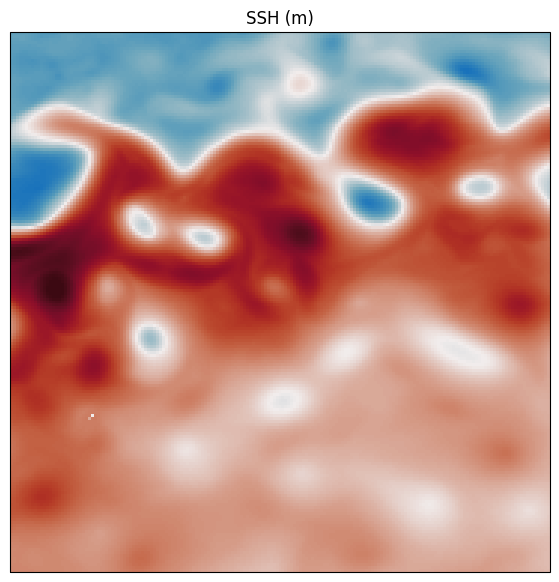

In [99]:
model_dir = '/Volumes/JCHD/NOC/data/eNATL60/1h_GS12/'
model_file = 'eNATL60-BLB002_sossheig_1h_GS12_y2009m10d01.nc'

g = RegularGridDataset(
    model_dir+model_file,
    'lon',
    'lat'
)

ax = start_axes("SSH (m)")
m = g.display(ax, "sossheig", vmin=-1, vmax=1, cmap=cmo.balance)

- We can derive the zonal and meridional velocity components by taking derivates of the sea surface height field. The velocity components are used to help detect closed contours

- Following the pyeddytracker workflow, we apply a high-pass filter to remove large scale processes such as geostrophic currents and highlight the mesoscale

In [151]:
g.bessel_high_filter("sossheig", 700)
ax = start_axes("SSH filtered (m) (500 km)")
m = g.display(ax, "sossheig", vmin=-0.8, vmax=0.8, cmap=cmo.balance)
update_axes(ax, m)

KeyError: 'sossheig'

In [114]:
date = datetime(2016, 5, 15)
kw_ident = dict(
    date=date, step=0.002, shape_error=70, sampling=30, uname="u", vname="v"
)
a, c = g.eddy_identification("sossheig", **kw_ident)

/Users/jakecunningham/opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(bool, UniTuple(int64 x 2))
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(bool, UniTuple(int64 x 2))':
       No match.

During: typing of intrinsic-call at /Users/jakecunningham/opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/generic.py (280)

File "../../../../opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/generic.py", line 280:
def interp2d_bilinear(x_g, y_g, z_g, m_g, x, y):
    <source elided>
            if not masked:
                if m_g[i0, j0] or m_g[i0, j1] or m_g[i1, j0] or m_g[i1, j1]:
                ^

During: resolving callee type: type(CPUDispatcher(<function interp2d_bilinear at 0x7f85e5148a60>))
During: typing of call at /Users/jakecunningham/opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/generic.py (201)

During: resolving callee type: type(CPUDispatcher(<function interp2d_bilinear at 0x7f85e5148a60>))
During: typing of call at /Users/jakecunningham/opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/generic.py (201)


File "../../../../opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/generic.py", line 201:
def interp2d_geo(x_g, y_g, z_g, m_g, x, y, nearest=False):
    <source elided>
    else:
        return interp2d_bilinear(x_g, y_g, z_g, m_g, x, y)
        ^

During: resolving callee type: type(CPUDispatcher(<function interp2d_geo at 0x7f85e5148700>))
During: typing of call at /Users/jakecunningham/opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/dataset/grid.py (129)

During: resolving callee type: type(CPUDispatcher(<function interp2d_geo at 0x7f85e5148700>))
During: typing of call at /Users/jakecunningham/opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/dataset/grid.py (129)


File "../../../../opt/anaconda3/envs/dsg_env/lib/python3.9/site-packages/py_eddy_tracker/dataset/grid.py", line 129:
def mean_on_regular_contour(
    <source elided>
    x_new, y_new = uniform_resample(x_val, y_val, num_fac, fixed_size)
    values = interp2d_geo(x_g, y_g, z_g, m_g, x_new[1:], y_new[1:])
    ^
